# Applying the configuration model

## Why random graphs?
In an early assignment we compared a BA network with an ER graph and saw that the degree distribution and shortest path length were quite different. If all we wanted to know was how the degree distributions were different than an ER graph isn't an unreasonable choice. However, as you learned in the reading and from looking at several different real world graphs you should be aware by now that most graphs don't have a simple poisson degree distribution. So while the ER graph is a simple model, it unfortunately isn't a good null model. 

Null models are often used in hypothesis testing to aid in the acceptance/rejection of some alternative hypothesis. The null, being the default assumption. In network science null models can also be used for statistical hypothesis testing and for determining whether certain graph features are responsible for some characteristic of the graph or some pattern of behavior on the graph (e.g. epidemic models or random walkers). 

The null model should match some of the real graph's topological characteristics but should otherwise be random. The configuration model allows us to hold the degree sequence constant while investigating other graph characteristics.

## Back to dolphins
Lets build a mock hypothesis using the [dolphin social network](http://www-personal.umich.edu/~mejn/netdata/dolphins.zip). My hypothesis is that dolphins have a posh and very exclusive culture. Popular dolphins only hang with other popular dolphins, while the loners are stuck to mingle among themselves. A sad state of affairs, but social life is hard in the pods. How might we test this?

There happens to be a similarity measure called [assortativity](https://en.wikipedia.org/wiki/Assortativity) where nodes of a certain type tend to be connected to nodes of the same type. In networkx there is a function called [degree assortativity](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html?highlight=degree_assortativity_coefficient#networkx.algorithms.assortativity.degree_assortativity_coefficient) which tells us how strongly nodes of similar degree are attached to each other. If the network has high degree assortativity, then low degree nodes will be connected to other low degree nodes, and high degree nodes will be connected to other high degree nodes. Conversely, low degree assortativity (or even disassortativity) would imply no (or negative) relationship. 

Excellent, so we have a measure, but what do we compare our graph too? It wouldn't really be appropriate to compare it to an ER graph because the nodes all have different degrees which are about the same and normally distributed. Instead, we want to compare our dolphin network to a graph with the same degree distribution, and that is where the configuration model comes in.

## Testing the dolphin hypothesis
We are going to do a rough test for our hypothesis by calculating the z-score for our dolphin network's degree assortativity coefficient. We will do this by generating a bunch of configuration models based on the dolphin degree sequence and calculating the assortativity coefficient for those null graphs. We can then compare our real network with the null model. If our z-score is high then it is unlikely that the dolphin network's assortativity can be accounted for by just the degree-sequence of a random graph, which means something more interesting is at work.

Lets carry out this experiment:

In [8]:
# We should load networkx and scipy (which has statistical tools)
import networkx as nx
import scipy.stats as stats

# Lets load the dolphin social network
dolphin_net = nx.read_gml("dolphins.gml")

# Often networkx will auto-load graphs as MultiGraphs
# I know this network is simple, so I will make sure it is of graph type Graph.
# Don't do this if your graph is directed. Directed graphs are of type DiGraph
dolphin_net = nx.Graph(dolphin_net)
print(type(dolphin_net).__name__)

Graph


Now that the graph is loaded in lets calculate the degree assortativity:

In [9]:
real_assortativity = nx.degree_assortativity_coefficient(dolphin_net)
print(real_assortativity)

-0.04359402821531252


Interesting! So it appears that the network is disassortative, so it seems like our hypothesis about the dolphins is falling appart, but we still need to compare it to a null model in order to determine whether there is anything of interest to be pursued here.

Networkx has a [configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration_model) function that can be used to generate our null models. We can use it by passing it a degree sequence, which we will do using the dolphin network:

In [10]:
# nx.degree returns a dictionary, but all we want is a list of the
# degrees. We can get this by getting the dictionary values and
# converting those values to a list.
dolphin_degree_sequence = list(dict(nx.degree(dolphin_net)).values())

# We need to generate enough null graphs to make a reasonable assessment of the null distribution
model_assortativity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    null_graph = nx.configuration_model(dolphin_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    null_graph = nx.Graph(null_graph) # removes parallel edges
    null_graph.remove_edges_from(null_graph.selfloop_edges()) # removes self-loops
    
    # Calculate the model's assortativity and add it to the list
    model_assortativity.append(nx.degree_assortativity_coefficient(null_graph))

Now we can calculate the z-scores using scipy's [zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) function. It will print out the z-scores for all the elements of the distribution. If we assume that the dolphin network came from the null distribution then we can calculate the z-score for the dolphin network:

In [11]:
# Prepend the real assortativity to the model list and have scipy calculate the zscores
zscores = stats.zscore([real_assortativity] + model_assortativity)

# Just print out the first score which corresponds to the real network
print(zscores[0])

0.04538910328246489


A z-score corresponds to how many standard deviations out from the mean the sample is. A score of +1 would be one standard deviation above the mean. Since the score is close to zero we can safely conclude that the disassortativity we observed in the dolphin network is explainable entirely from the degree sequence and no other special properties of the network.

However, this doesn't mean there aren't low-level features hidden in the network. The degree assortativity score is an aggregative measure, and it can obfuscate local deviations from assortativity that are non-random. There is also a score for the local degree assortativity, but we will not pursue that further here.

Now that we have a distribution of null assortativities we can also visualize the distribution and plot our dolphin network's assortativity along with it:

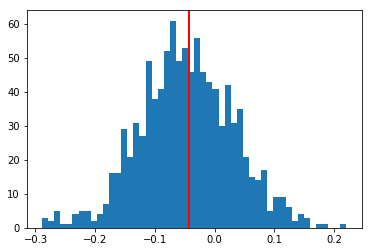

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(model_assortativity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(real_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

And there we have it! We have fair reason to conclude that not only is the hypothesis wrong but the surprising disassortativity we found really wasn't anything special after all. [note: reference for [`axvline`](http://matplotlib.org/api/pyplot_api.html?highlight=axvline#matplotlib.pyplot.axvline) in matplotlib]

# Assignment

1. Pick a graph of your choosing. You can use the graphs you are using for your project or any other real-world graph. Here are a couple places you can find some: [pajek datasets](http://vlado.fmf.uni-lj.si/pub/networks/data/), [Newman's datasets](http://www-personal.umich.edu/~mejn/netdata/). [note: if you use directed graphs makes sure you use the corresponding function [`directed_configuration_model`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.directed_configuration_model.html?highlight=configuration_model#networkx.generators.degree_seq.directed_configuration_model)]

2. Construct two simple hypotheses around two different measures that you can calculate from the graph. Here is a [list of algorithms that networkx has](https://networkx.github.io/documentation/stable/reference/algorithms/index.html). You aren't limited by measures networkx can calculate. However, do not use a measure that depends entirely on the degree sequence. For instance, it would be silly to compare average degree to the random networks generated by the configuration model because it uses the same degree sequence and so will have the same average degree.

3. Carry out a simple hypothesis test for both hypotheses. It can be similar to what I showed here. You are welcome to carry it out in a more robust manner, but the focus of this assignment is getting a hang of using configuration models as null models. Here is a link to [Statistics for Hackers](https://speakerd.s3.amazonaws.com/presentations/7e68b43159d646cf81eda9e1bded8213/Statistics_for_Hackers_-_PyCon2016.pdf). It has a nice little python tutorial for how you can carry out hypothesis testing without all the hard math. Even if you don't use it for this assignment I highly recommend checking it out.

4. Provide quantitative analysis and a graphical illustration of your results. It should be clear that your hypothesis was validated/invalidated/inconclusive.

5. Answer the following questions:
  * What graph are you using?
  * What are you hypotheses?
  * What measures will you be using to test your hypotheses? How do these measures accomplish this?
  * Explain your results. Were they surprising? Did they confirm or reject your hypotheses?
  * From these tests, what have you learned about the structure of the network you were investigating?

6. Once you are complete submit your Jupyter notebook to Canvas.

## Case 1 - Net Science Assortativity
**Graph** - Co-Authorship in Network Science 

**Source** - http://www-personal.umich.edu/~mejn/netdata/netscience.zip

**Hypothesis** - Famous authors are cited the most and others work in silos. This hypothesis is on the similar lines of "Rich follows Richer" 

I will be checking **assortativity measure** to capture this notion. It is similarity measure and it will figure out how many nodes are similar and how many are odds.


In [13]:
netsci = nx.read_pajek('netsience.net')
largest_component=max(nx.connected_component_subgraphs(netsci), key=len)
netsci_graph = nx.Graph(largest_component)
print(type(netsci_graph).__name__)

Graph


In [14]:
netsci_real_assortativity = nx.degree_assortativity_coefficient(netsci_graph)
print(netsci_real_assortativity)

-0.08167784834672846


In [15]:
netsci_degree_sequence = list(dict(nx.degree(netsci_graph)).values())
netsci_model_assortativity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    netsci_null_graph = nx.configuration_model(netsci_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    netsci_null_graph = nx.Graph(netsci_null_graph) # removes parallel edges
    netsci_null_graph.remove_edges_from(netsci_null_graph.selfloop_edges()) # removes self-loops
 

In [16]:
netsci_degree_sequence = list(dict(nx.degree(netsci_graph)).values())
netsci_model_assortativity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    netsci_null_graph = nx.configuration_model(netsci_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    netsci_null_graph = nx.Graph(netsci_null_graph) # removes parallel edges
    netsci_null_graph.remove_edges_from(netsci_null_graph.selfloop_edges()) # removes self-loops
    
    # Calculate the model's assortativity and add it to the list
    netsci_model_assortativity.append(nx.degree_assortativity_coefficient(netsci_null_graph))

In [17]:
netsci_zscores = stats.zscore([netsci_real_assortativity] + netsci_model_assortativity)

# Just print out the first score which corresponds to the real network
print(netsci_zscores[0])

-1.9791191897849254


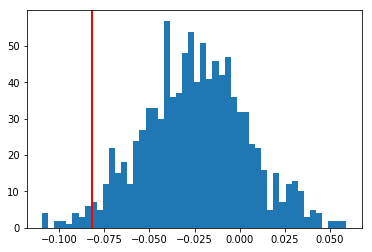

In [24]:
plt.hist(netsci_model_assortativity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(netsci_real_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

** Results**  
From the results, we see that netscience network is assortative. Our Hypothesis is confirmed by this.
Real assortativity stands at -1.97 standard deviations than null distribution model.
This is not suprising because we know that authors like Barabasi are referred most among the community than others.

From these tests, we wee that net science is not a randon graph structure. It has different degree distribution which displays small world phenomenon. Some nodes are more connected than others.

## Case 2 - Dolphins Transitivity

Graph - Dolphin Social Network

Source - http://www-personal.umich.edu/~mejn/netdata/dolphins.zip

Hypothesis - Dolphins are closely knit society where all dolphins know each other.

I will be checking transitivity measure to capture this notion. Transitivity tells us that if A is freind of B and A is also friend of C then whether B and C are friend or not. In other words, is there any "triad" among those 3 nodes. If transitivity is 1 , then it means that its is perfectly closed network. 

In [32]:
dolphin_real_transitivity = nx.transitivity(dolphin_net)
print(dolphin_real_transitivity)

0.3087757313109426


In [36]:
dolphin_degree_sequence = list(dict(nx.degree(dolphin_net)).values())
dolphin_model_transitivity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    dolphin_null_graph = nx.configuration_model(dolphin_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    dolphin_null_graph = nx.Graph(dolphin_null_graph) # removes parallel edges
    dolphin_null_graph.remove_edges_from(dolphin_null_graph.selfloop_edges()) # removes self-loops
    
    # Calculate the model's assortativity and add it to the list
    dolphin_model_transitivity.append(nx.transitivity(dolphin_null_graph))

In [37]:
dolphin_transitivity_zscores = stats.zscore([dolphin_real_transitivity] + dolphin_model_transitivity)

# Just print out the first score which corresponds to the real network
print(dolphin_transitivity_zscores[0])

11.042868081008177


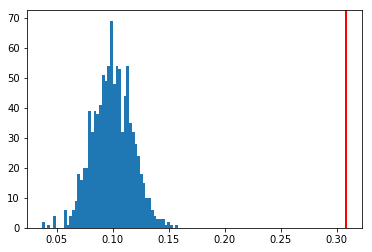

In [38]:
plt.hist(dolphin_model_transitivity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(dolphin_real_transitivity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

** Results**
From the results, it is clear that our hypothesis is rejected. Transitivity in dolphin network stands at 11 standard deviations than null model.
Real transitivity of dolphin network is at 0.3 which means all of them are not perfectly connected. The results are not surprising.

The tests show that random networks don't show transitivity property as it is seen in real social networks. We see more "cliques" in real social network than random network. However, real network is rarely completely closed network.